# The TimelapseERT class
Since pyGIMLi we have a class dedicated to timelapse ERT processing and inversion. The inversion supports different schemes from simple individual over constrained inversion to fully coupled ("4D") inversion using pyGIMLi's `MultiFrameModelling` modelling framework.
Additionally, we created a github repository https://github.com/gimli-org/timelapseERT that holds published data and according scripts demonstrated how to achieve the published results, according to the FAIR data standards.

This notebook is a simplistic model for a synthetic case.

In [21]:
# First we import pygimli and some modules
import numpy as np
import matplotlib.pyplot as plt
import pygimli as pg
import pygimli.meshtools as mt
from pygimli.physics import ert

We create a data container with a dipole-dipole array.

Data: Sensors: 41 data: 465, nonzero entries: ['a', 'b', 'k', 'm', 'n', 'valid']


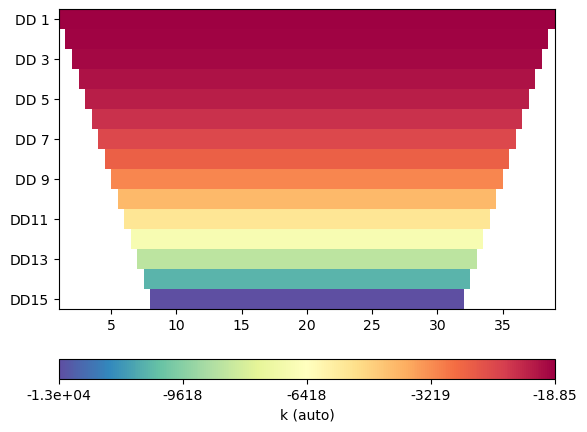

In [22]:
scheme = ert.createData(elecs=41, spacing=1.0, schemeName='dd', maxSeparation=15)
ert.show(scheme, "k");
print(scheme)

Our subsurface is a three-layer model with an aquifer in the middle, into which synthetic tracer is injected that is moving to the right.

Mesh: Nodes: 2927 Cells: 5541 Boundaries: 8467


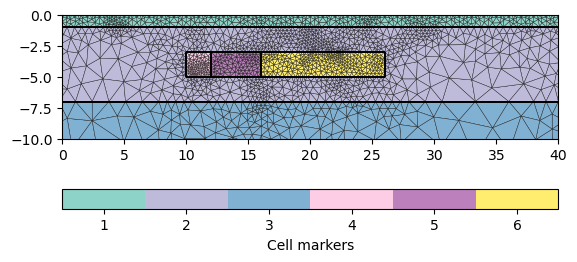

In [23]:
world = mt.createWorld(start=[-50, 0], end=[100, -50], boundary=1,
                       layers=[-1, -7], worldMarker=True)
for pos in scheme.sensorPositions():
    world.createNode(pos, marker=-99)
    world.createNode(pos+pg.RVector3(0, -0.2))

# Create some heterogeneous block
plcs = [world]
pos = [10, 12, 16, 26]
nT = len(pos) - 1  # number of time steps
for i in range(nT):
    block = mt.createRectangle(start=[pos[i], -5], end=[pos[i+1], -3],
                               area=0.1, marker=4+i)
    plcs.append(block)

geom = mt.mergePLC(plcs)
mesh = mt.createMesh(geom, quality=34.4)
print(mesh)
ax, _ = pg.show(mesh, markers=True, boundaryMarkers=False, showMesh=True)
ax.set_xlim(0, 40)
ax.set_ylim(-10, 0);

We associate 100 Ohmm to the first layer, 50 to the second and 20 to the last one. At the beginning, the anomalies have the same resistivity as the aquifer.

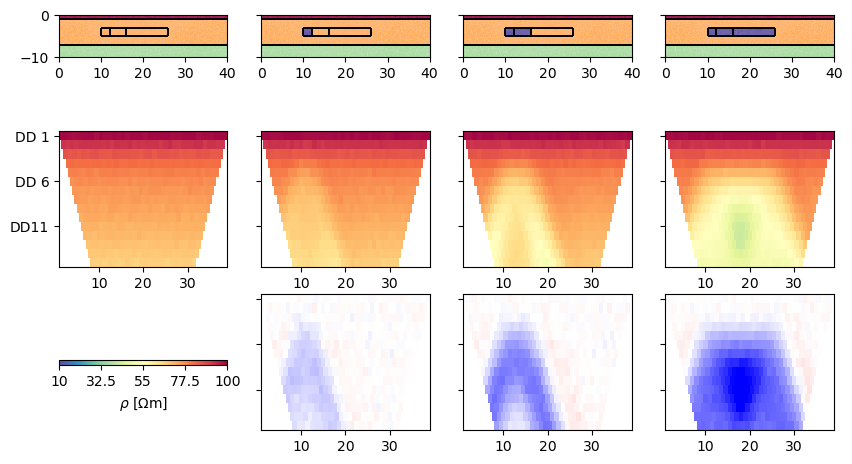

In [35]:
rhomap = [[1, 100.0], [2, 50.0], [3, 20.0], [4, 50.0], [5, 50.0], [6, 50.0]]
noise = dict(noiseLevel=0.01, noiseAbs=0, verbose=False)
mgr = ert.Manager()
data = ert.simulate(mesh=mesh, res=rhomap, scheme=scheme, **noise)
rhoTracer = 10
cDict = dict(colorBar=False, cMin=10, cMax=100, logScale=1, cMap='Spectral_r')
fig, ax = pg.plt.subplots(figsize=(10, 6), ncols=nT+1, nrows=3)
DATA = []
for i in range(nT+1):
    pg.show(mesh, rhomap, ax=ax[0, i], **cDict)
    ax[0, i].set_xlim(0, 40)
    ax[0, i].set_ylim(-10, 0)
    data = ert.simulate(mesh, res=rhomap, scheme=scheme, **noise)
    data.save('data{:d}.dat'.format(i))
    DATA.append(data)
    ert.show(data, ax=ax[1, i], **cDict)
    ratio = data('rhoa') / DATA[0]('rhoa')
    if i > 0:
        ert.show(data, ratio, ax=ax[2, i],
                cMap='bwr', cMin=1/2, cMax=2, colorBar=False)
    if i < nT:
        rhomap[3+i][1] = rhoTracer

for i in range(nT):
    for j in range(3):
        ax[j, i+1].set_yticklabels([])

cDict.pop('colorBar')
cDict['label'] = r'$\rho$ [$\Omega$m]'
pg.viewer.mpl.colorbar.createColorBarOnly(ax=ax[2, 0], **cDict)
ax[2, 0].set_aspect(3)

We initialize the `TimelapseERT` class by passing the list of data. Other ways are passing
* a single data file that either holds all timestep or is accompagnied by another file with the apparent resistivites (and optionally errors) as a matrix
* a file name with a * in it that points to a number of data (e.g. `data/*.dat`) to be read sequentially
Note that in the latter case or when passing a list of `DataContainerERT` the data will be homogenized, i.e. brought to a single `DataContainerERT` and a apparent resistivity matrix where non-existing values are masked out.

In the initialization process, one can pass a list of `datatime` objects to specify measuring times. Otherwise they are retrieved from the filenames or just set to equidistant intervals.

In [25]:
tl = ert.TimelapseERT(DATA)
print(tl)

27/10/23 - 12:53:29 - pyGIMLi - INFO - Cache c:\Guenther.T\src\gimli\gimli\pygimli\physics\ert\ert.py:createGeometricFactors restored (0.0s x 3): C:\Guenther.T\Anwendungsdaten\pygimli\Cache\11065226757338895596


Timelapse ERT data:
Data: Sensors: 41 data: 465, nonzero entries: ['a', 'b', 'k', 'm', 'n', 'valid']
4 time steps from 2023-10-27 12:53 to 2023-10-30 12:53


Masking of data can be achieved by `tl.mask()` specifying minimum and maximum apparent resistivity or maximum error.
Additionally, you can filter the data by `tl.filter()` to set maximum geometric factor or remove/select timesteps.

In [26]:
# This command can generate multi-page pdfs of the data.
# tl.generateDataPDF(cMin=30, cMax=100)

One can do a single timestep inversion using `tl.invert(t=i)`. If this argument is omitted, are timesteps are inverted sequentially, always using the ERT Manager.
By default, the first model is used as reference, i.e. the model difference is constrained.
This can be deactivatey by `isReference=False`.
The reference model can be moved along with the inversion by by `creep=True` so that the difference to the preceding step is constrained.
One can specify regularization options using a `reg` dictionary and, if wanted, a different regularization for the timesteps by `regTL`.

In [32]:
tl.invert(zWeight=0.3, lam=100)
print(tl.chi2s)

27/10/23 - 12:54:29 - pyGIMLi - INFO - Setting starting model as reference!
27/10/23 - 12:54:30 - pyGIMLi - INFO - Setting starting model as reference!


27/10/23 - 12:54:30 - pyGIMLi - INFO - Setting starting model as reference!


27/10/23 - 12:54:31 - pyGIMLi - INFO - Setting starting model as reference!






[0.19368215817918874, 0.12916425980093427, 0.15319449029922877, 0.4526137267974686]


After inversion, on can show the models by `tl.showAllModels`. For convenience (and if many timesteps are involved), one can also generate a multi-page pdf by `tl.generateModelPDF`.
The user can access the individual models by `tl.models[i]` and plot them using `tl.mgr.showResult(tl.models[i])` or `pg.show(tl.pd, tl.models[i])`.

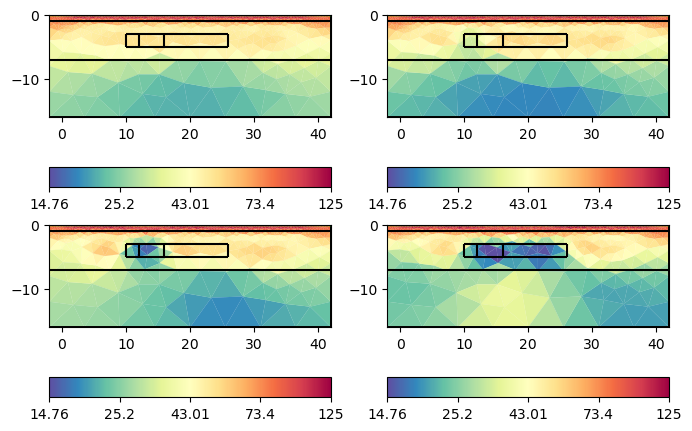

In [33]:
ax = tl.showAllModels();
for a in ax.flat:
    pg.viewer.mpl.drawPLC(a, geom, fillRegion=False, fitView=False)

We can observe the major laying and also clear indications of the tracer injection.
Often, one is interested in the changes or differences, which are in the usual logarithmic scale the ratios.

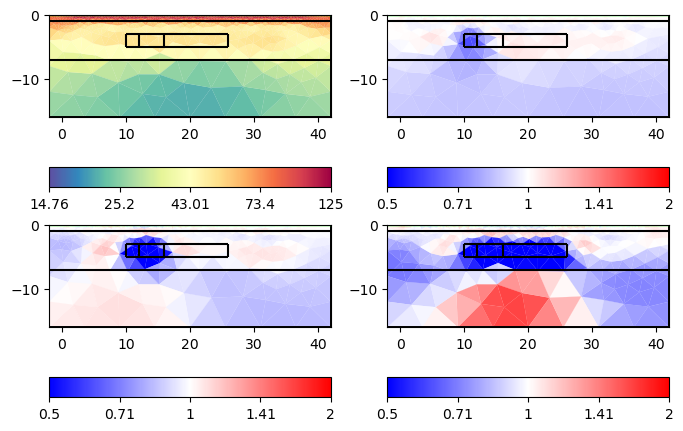

In [34]:
ax = tl.showAllModels(ratio=True, rMax=2)
for a in ax.flat:
    pg.viewer.mpl.drawPLC(a, geom, fillRegion=False, fitView=False)

Here we see that we clearly see all the anomalies, but the first one is very slight due to its size. Additionally, we see artifacts of increased resistivity.

As powerful alternative to a sequential inversion, one can invert all timesteps together with constraints along the spatial and temporal dimensions. For this there is a special call `fullInversion` that might take more memory, but is usually not slower than a sequential inversion and moreover more robust.

In [30]:
tl.fullInversion(zWeight=0.3, lam=100)

27/10/23 - 12:53:34 - pyGIMLi - INFO - Found 2 regions.
27/10/23 - 12:53:34 - pyGIMLi - INFO - Region with smallest marker (1) set to background
27/10/23 - 12:53:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
27/10/23 - 12:53:35 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
27/10/23 - 12:53:35 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 2030 Cells: 3820 Boundaries: 2984
27/10/23 - 12:53:35 - pyGIMLi - INFO - Starting inversion.


708 model cells
Mesh: Nodes: 2030 Cells: 3820 Boundaries: 2984
fop: <pygimli.frameworks.timelapse.MultiFrameModelling object at 0x000001ADB7D29E50>
Data transformation: <pgcore._pygimli_.RTrans object at 0x000001ADB7D36BE0>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x000001ADB7D38450>
min/max (data): 22.11/99.69
min/max (error): 3%/3%
min/max (start model): 53.09/53.09
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  135.17
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =    4.28 (dPhi = 94.18%) lam: 100.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    0.76 (dPhi = 54.47%) lam: 100.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.76)                   #
###########################################################

2832 [72.75968284056749,...,32.508663934908434]

In [1]:
ax = tl.showAllModels(ratio=True, rMax=2)
for a in ax.flat:
    pg.viewer.mpl.drawPLC(a, geom, fillRegion=False, fitView=False)

NameError: name 'tl' is not defined

Here, the results are gone due to the stabilizing smoothness across the time. To change the temporal smoothness, one can e.g. use `tl.fullInversion(scalef=0.5)` for more changes in time.